Hallo, Kak Reviewer. 

Perkenalkan, namaku Muhammad Imron, bisa dipanggil Imron. Di submission Time Series ini, aku pakai dataset dari UCI Machine Learning namanya Tetuan City power consumption.csv. Rencananya di submission ini aku bakalan nerapin time series temperature.

Mohon bantuannya kak, untuk direview.

Terima kasih

---

https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city

**Import Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

**Dataset Exploration**

In [21]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Tetuan City power consumption.csv')
df.tail()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504
52415,12/30/2017 23:50,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820


In [22]:
df.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


In [23]:
df.isnull().sum()

DateTime                     0
Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

**Minimal MAE yang harus dicapai**

In [24]:
treshold = (df['Temperature'].max() - df['Temperature'].min()) * 10/100
print('Minimal MAE yang harus dicapai : ', treshold)

Minimal MAE yang harus dicapai :  3.6763


Text(0.5, 1.0, 'Temperature Average')

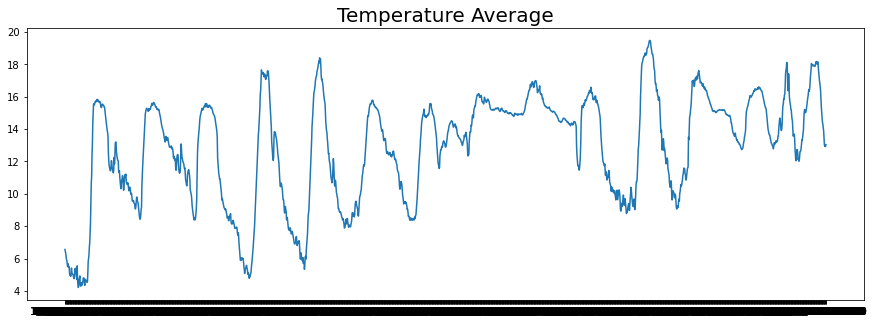

In [25]:
dates = df['DateTime'].values
temp = df['Temperature'].values

plt.figure(figsize=(15,5))
plt.plot(dates[:2000], temp[:2000])
plt.title('Temperature Average',
          fontsize=20)

**Preprocessing**

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [40]:
train_x, val_x, train_y, val_y = train_test_split(dates, temp, test_size=0.2, shuffle=False)

train_set = windowed_dataset(train_y, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(val_y, window_size=60, batch_size=100, shuffle_buffer=1000)

**Arsitektur Model**

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

**Callbacks**

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min',
                               verbose=1, patience=3)

callbacks = [early_stopping]

**Model Compilling and Fitting**

In [43]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=callbacks)

Epoch 1/100
419/419 [==============================] - 13s 24ms/step - loss: 9.8591 - mae: 10.3468 - val_loss: 4.1468 - val_mae: 4.6160
Epoch 2/100
419/419 [==============================] - 10s 23ms/step - loss: 1.5261 - mae: 1.9589 - val_loss: 1.2434 - val_mae: 1.6604
Epoch 3/100
419/419 [==============================] - 10s 23ms/step - loss: 0.4328 - mae: 0.7643 - val_loss: 0.2877 - val_mae: 0.6076
Epoch 4/100
419/419 [==============================] - 11s 26ms/step - loss: 0.1634 - mae: 0.4246 - val_loss: 0.1893 - val_mae: 0.4663
Epoch 5/100
419/419 [==============================] - 10s 23ms/step - loss: 0.1301 - mae: 0.3768 - val_loss: 0.1502 - val_mae: 0.4164
Epoch 6/100
419/419 [==============================] - 10s 23ms/step - loss: 0.1126 - mae: 0.3460 - val_loss: 0.1246 - val_mae: 0.3742
Epoch 7/100
419/419 [==============================] - 11s 26ms/step - loss: 0.0943 - mae: 0.3136 - val_loss: 0.1077 - val_mae: 0.3457
Epoch 8/100
419/419 [==============================] -

In [45]:
score = model.evaluate(val_set, verbose=1)

105/105 [==============================] - 2s 15ms/step - loss: 0.0425 - mae: 0.2082


In [50]:
print('Model telah berhasil mencapai minimal MAE : {} < {}'.format(score[1], treshold))

Model telah berhasil mencapai minimal MAE : 0.2081875503063202 < 3.6763


**Grafik Loss dan MAE**

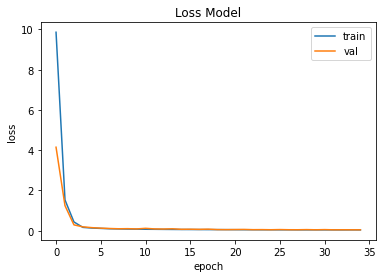

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

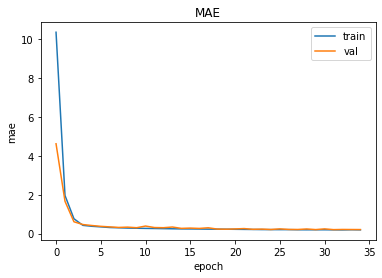

In [52]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()